In [1]:
import tensorflow as tf
import keras 
from keras.layers import Conv2D , MaxPooling2D
from keras import backend as k
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv(r"C:\Users\MinhThw\OneDrive\Desktop\DATN\data\hyper.csv", sep=";")

In [3]:

df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['BMI'] = pd.to_numeric(df['BMI'].str.replace(',', '.'), errors='coerce')
df['Diabetes'] = df['Diabetes'].map(lambda x: 0 if pd.isna(x) else 1)
df['CI'] = df['Cerebral Infarction'].map(lambda x: 0 if pd.isna(x) else 1)
df['CD'] = df['Cerebrovascular Disease'].map(lambda x: 0 if pd.isna(x) else 1)
df['SBP'] = df['Systolic Blood Pressure']
df['DBP'] = df['Diastolic Blood Pressure']
df = df.drop(['Num', 'Subject_ID','Cerebral Infarction', 'Cerebrovascular Disease', 'Diastolic Blood Pressure', 'Systolic Blood Pressure'], axis =1)
df['Hypertension'] = df['Hypertension'].map(lambda x: 0 if x == 'Normal' else 1)

In [4]:
print (df)

     Sex  Age  Height  Weight  Heart Rate        BMI  Diabetes  Hypertension  \
0      0   45     152      63          97  27.268006         0             1   
1      0   50     157      50          76  20.284799         0             1   
2      0   47     150      47          79  20.888889         0             0   
3      1   45     172      65          87  21.971336         0             1   
4      0   46     155      65          73  27.055151         0             1   
..   ...  ...     ...     ...         ...        ...       ...           ...   
214    1   24     180      70          77  21.604938         0             0   
215    0   25     156      47          79  19.312952         0             0   
216    1   25     176      55          72  17.755682         0             1   
217    1   25     173      63          67  21.049818         0             0   
218    1   24     175      58          65  18.938776         0             0   

     CI  CD  SBP  DBP  
0     0   0  16

In [5]:
# Kiểm tra thông tin cơ bản về dữ liệu
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           219 non-null    int64  
 1   Age           219 non-null    int64  
 2   Height        219 non-null    int64  
 3   Weight        219 non-null    int64  
 4   Heart Rate    219 non-null    int64  
 5   BMI           219 non-null    float64
 6   Diabetes      219 non-null    int64  
 7   Hypertension  219 non-null    int64  
 8   CI            219 non-null    int64  
 9   CD            219 non-null    int64  
 10  SBP           219 non-null    int64  
 11  DBP           219 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 20.7 KB
None
              Sex         Age      Height      Weight  Heart Rate         BMI  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.474886   57.168950  161.228311   60.191781   73.639269   23.107

In [6]:
# Kiểm tra các giá trị bị thiếu
print(df.isnull().sum())

Sex             0
Age             0
Height          0
Weight          0
Heart Rate      0
BMI             0
Diabetes        0
Hypertension    0
CI              0
CD              0
SBP             0
DBP             0
dtype: int64


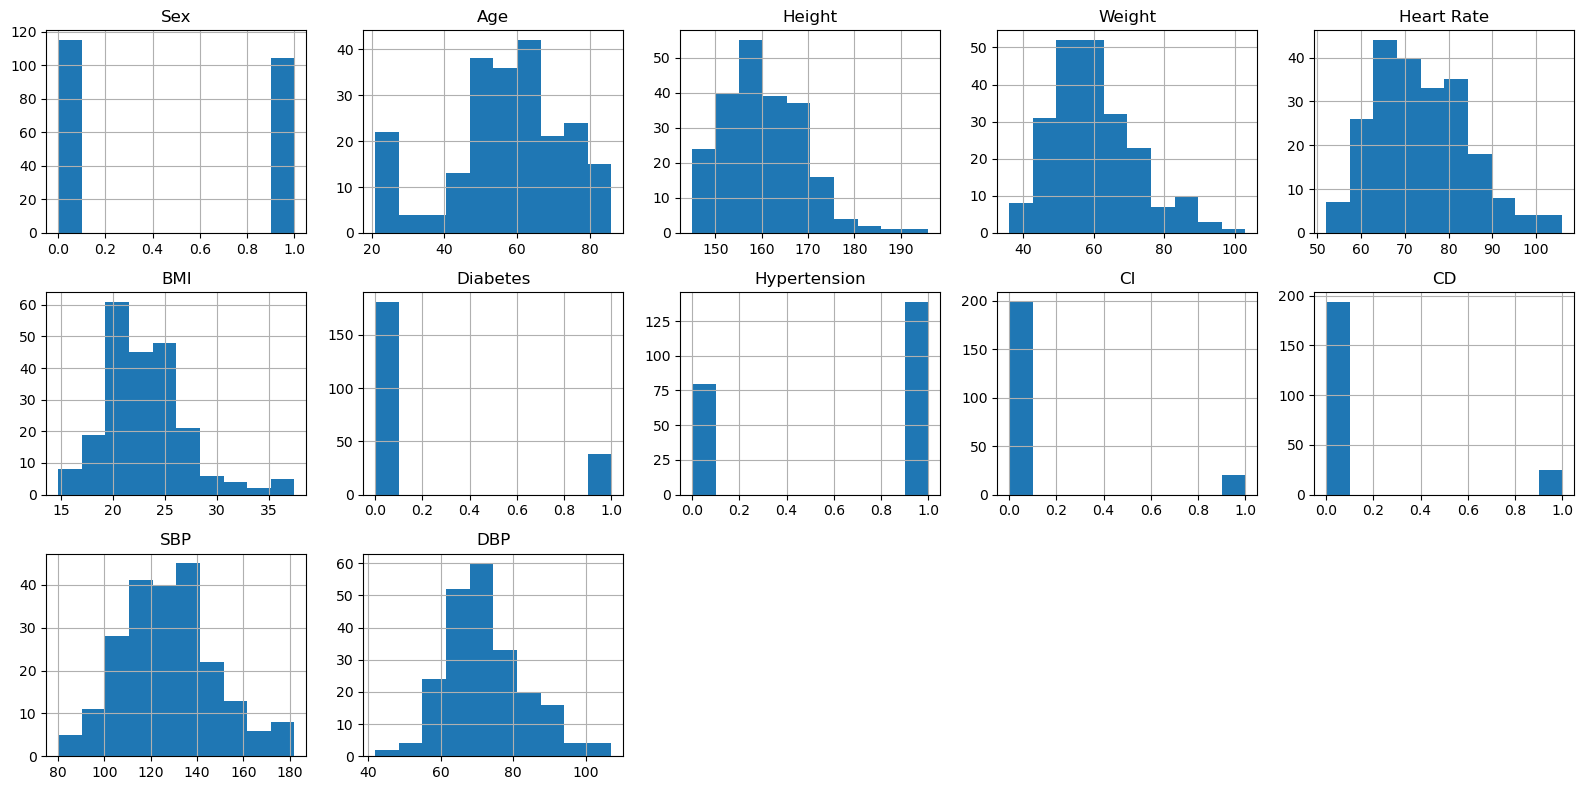

In [7]:
# Kiểm tra phân bố của các thuộc tính
plt.figure(figsize=(16, 8))
for i, col in enumerate(df.columns):
    plt.subplot(3, 5, i+1)
    df[col].hist()
    plt.title(col)
plt.tight_layout()
plt.show()

In [8]:
import plotly.graph_objects as go

corr_matrix = df.corr()

fig = go.Figure(data=go.Heatmap(
                   z=corr_matrix.values,
                   x=corr_matrix.columns,
                   y=corr_matrix.columns,
                   colorscale='YlOrRd',
                   text=corr_matrix.values, # hiển thị giá trị tương quan
                   #texttemplate='%.2f' # định dạng giá trị tương quan với 2 chữ số thập phân
))

fig.update_traces(hoverinfo='text+z') # hiển thị giá trị tương quan khi di chuột qua
fig.update_layout(title='Correlation Matrix',
                 width=1000,
                 height=800)
fig.show()

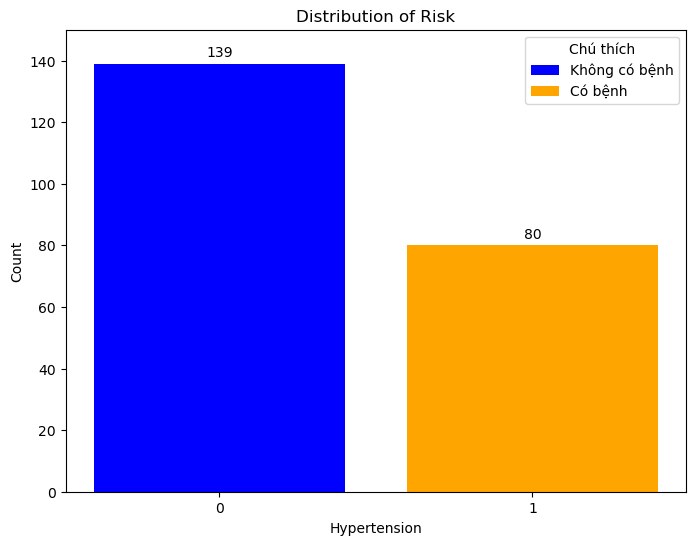

In [9]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange']
bars = plt.bar(range(2), df['Hypertension'].value_counts(), width=0.8, color=colors)
plt.xticks(range(2), ['0', '1'])
plt.title('Distribution of Risk')
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.ylim(0, 150)

# Tạo các handles cho legend
handles = bars
labels = ['Không có bệnh', 'Có bệnh']

plt.legend(handles, labels, title='Chú thích', loc='upper right')
plt.bar_label(bars, padding=3, fontsize=10)
plt.show()

In [10]:
# Phân tích mối quan hệ giữa các thuộc tính và biến mục tiêu
#plt.figure(figsize=(16, 8))
#for i, col in enumerate(df.columns[:-1]):
    #plt.subplot(3, 5, i+1)
    #sns.scatterplot(x=col, y='Risk', data=df)
    #plt.title(col)
#plt.tight_layout()
#plt.show()


In [11]:
# Tạo biến nhị phân (dummy variables) cho các feature định tính
columns_to_get_dummies = ['Sex', 'Diabetes', 'CI', 'CD']
data = pd.get_dummies(df, columns=columns_to_get_dummies).drop(['Sex_0', 'Diabetes_0', 'CI_0', 'CD_0'], axis=1)

# Chuẩn hóa (standardize) các feature định lượng
standardScaler = StandardScaler()
columns_to_scale = ['Age', 'Height', 'Weight', 'SBP', 'DBP', 'Heart Rate', 'BMI']
data[columns_to_scale] = standardScaler.fit_transform(data[columns_to_scale])

In [12]:
print (data)#.astype(int))

          Age    Height    Weight  Heart Rate       BMI  Hypertension  \
0   -0.768337 -1.127587  0.236798    2.180326  1.041372             1   
1   -0.452641 -0.516648 -0.859404    0.220334 -0.706481             1   
2   -0.642058 -1.371963 -1.112373    0.500333 -0.555281             0   
3   -0.768337  1.316169  0.405444    1.246997 -0.284352             1   
4   -0.705198 -0.761024  0.405444   -0.059665  0.988096             1   
..        ...       ...       ...         ...       ...           ...   
214 -2.094258  2.293672  0.827060    0.313667 -0.376059             0   
215 -2.031119 -0.638836 -1.112373    0.500333 -0.949728             0   
216 -2.031119  1.804921 -0.437788   -0.152998 -1.339503             1   
217 -2.031119  1.438357  0.236798   -0.619663 -0.515002             0   
218 -2.094258  1.682733 -0.184818   -0.806329 -1.043382             0   

          SBP       DBP  Sex_1  Diabetes_1   CI_1   CD_1  
0    1.625816  1.547085  False       False  False  False  
1    

In [13]:

#X = result.to_numpy()
  

# Chia thành tập huấn luyện và tập kiểm tra
data_row_dim = 1
data_col_dim = 13
X = data.drop(['Hypertension'], axis = 1).to_numpy()
print(X.shape)
#X = X.values.reshape(-1, data_row_dim, data_col_dim)
#print(X.shape)   
y_temp = data['Hypertension']
# Chuyển đổi kiểu dữ liệu của y thành số thực
y = y_temp.dropna().astype('float32').to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#X_train = X_train.reshape(X_train.shape[0],data_row_dim,data_col_dim,1)
#X_test = X_test.reshape(X_test.shape[0],data_row_dim,data_col_dim,1)
input_shape = (data_row_dim,data_col_dim,1)

print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#print('X_train.shape', X_test.shape)
print(X_train.shape[0],'Train Sample')
print(X_test.shape[0],'Test Sample')



(219, 11)
(153, 11) (153,)
(66, 11) (66,)
(153, 11) (153,)
(66, 11) (66,)
153 Train Sample
66 Test Sample


In [14]:
#Tạo Model

model = Sequential()
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

# Compile model
#model.compile( loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"]) # categorical_crossentropy'
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

# Model training
#history = model.fit(X_train,y_train , batch_size=128,epochs=100,verbose=1,validation_data=(X_test,y_test))
history= model.fit(X_train,y_train , batch_size=128,epochs=100,verbose=1,validation_data=(X_test,y_test))

#model.fit(X_train,y_train, batch_size=128, validation_data=(X_test,y_test), epochs=40, verbose=1)
print("The Model has Successfully Trained")


Epoch 1/100
2/2 [==============================] - 1s 257ms/step - loss: 0.6834 - accuracy: 0.4510 - val_loss: 0.6657 - val_accuracy: 0.8182
Epoch 2/100
2/2 [==============================] - 0s 43ms/step - loss: 0.6778 - accuracy: 0.5425 - val_loss: 0.6610 - val_accuracy: 0.8182
Epoch 3/100
2/2 [==============================] - 0s 40ms/step - loss: 0.6713 - accuracy: 0.5882 - val_loss: 0.6563 - val_accuracy: 0.8333
Epoch 4/100
2/2 [==============================] - 0s 42ms/step - loss: 0.6632 - accuracy: 0.6405 - val_loss: 0.6509 - val_accuracy: 0.8333
Epoch 5/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6671 - accuracy: 0.6209 - val_loss: 0.6457 - val_accuracy: 0.8333
Epoch 6/100
2/2 [==============================] - 0s 45ms/step - loss: 0.6485 - accuracy: 0.6993 - val_loss: 0.6411 - val_accuracy: 0.8636
Epoch 7/100
2/2 [==============================] - 0s 41ms/step - loss: 0.6532 - accuracy: 0.6797 - val_loss: 0.6365 - val_accuracy: 0.8636
Epoch 8/100
2/2 [==

In [15]:
#y_test = pd.DataFrame(y_test)
y_test

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

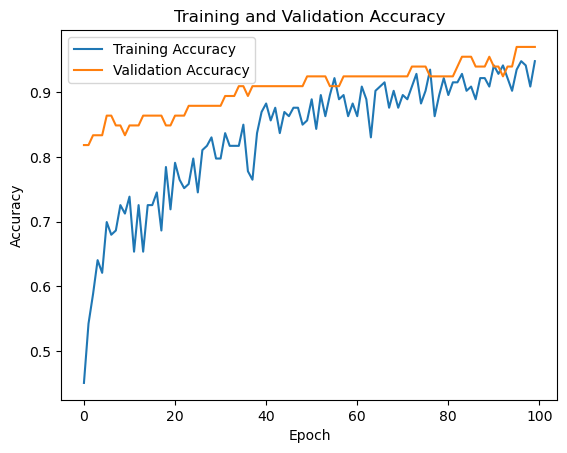

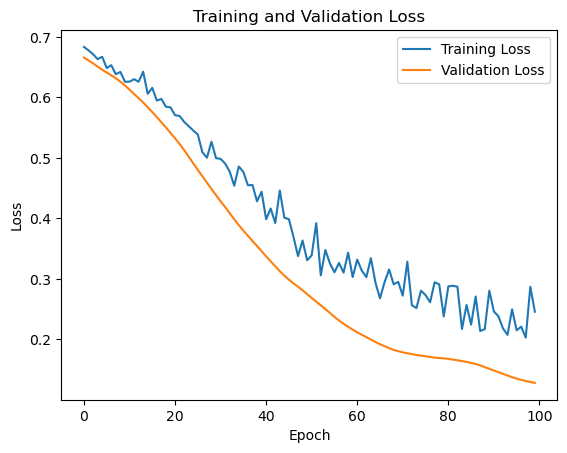

In [16]:
import matplotlib.pyplot as plt

# Lấy thông tin độ chính xác và mất mát từ lịch sử
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ độ chính xác
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ biểu đồ mất mát
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
predictions = model.predict(X_test)
predictions

3/3 [==============================] - 0s 2ms/step


array([[0.9958379 ],
       [0.8922219 ],
       [0.04693733],
       [0.989903  ],
       [0.9567693 ],
       [0.1996419 ],
       [0.9362276 ],
       [0.5620329 ],
       [0.5407665 ],
       [0.98836845],
       [0.99492884],
       [0.913994  ],
       [0.9995096 ],
       [0.983054  ],
       [0.97139406],
       [0.7090965 ],
       [0.4893312 ],
       [0.995103  ],
       [0.171828  ],
       [0.99344754],
       [0.02783403],
       [0.00586131],
       [0.95840746],
       [0.02265355],
       [0.01954881],
       [0.97091293],
       [0.99785906],
       [0.8241984 ],
       [0.95851165],
       [0.998467  ],
       [0.94842666],
       [0.04830089],
       [0.9997604 ],
       [0.96821   ],
       [0.98580325],
       [0.99983925],
       [0.93798554],
       [0.05557806],
       [0.98929965],
       [0.00334503],
       [0.04665203],
       [0.18938527],
       [0.99970573],
       [0.28318274],
       [0.91875994],
       [0.9688062 ],
       [0.97621447],
       [0.717

In [18]:
#y_pred = tf.argmax(predictions, axis=-1)
y_pred = tf.greater(predictions, .5)
y_pred

<tf.Tensor: shape=(66, 1), dtype=bool, numpy=
array([[ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [Fa

In [19]:
y_test

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
cm = confusion_matrix(y_test, y_pred)

In [22]:
print(cm)

[[18  1]
 [ 1 46]]


In [23]:
# Vẽ ma trận nhầm lẫn
#plt.figure(figsize=(5, 4))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.xlabel('Predicted Label')
#plt.ylabel('True Label')
#plt.title('Confusion Matrix')
#plt.show()

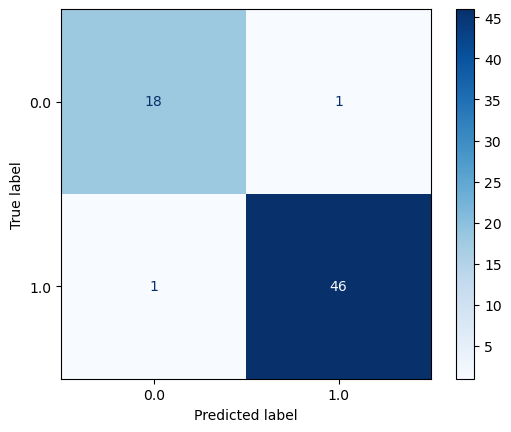

In [24]:
#y_pred = y_pred[:len(y_test)]
# Vẽ confusion matrix với scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Confusion Matrix')
plt.show()

In [25]:
print(classification_report(y_test,y_pred))
#unique_labels = np.unique(np.concatenate([y_test, y_pred]))
#print(confusion_matrix(y_test, y_pred, labels=unique_labels))
#print(classification_report(y_test, y_pred,  zero_division=1))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        19
         1.0       0.98      0.98      0.98        47

    accuracy                           0.97        66
   macro avg       0.96      0.96      0.96        66
weighted avg       0.97      0.97      0.97        66



In [26]:
from sklearn.metrics import roc_curve

y_true = y_test
y_scores = predictions


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
# In Tỷ Lệ Dương Tính Thực
print('Tỷ Lệ Dương Tính Thực (TPR):')
print(tpr)

Tỷ Lệ Dương Tính Thực (TPR):
[0.         0.0212766  0.93617021 0.93617021 0.9787234  0.9787234
 1.         1.        ]


In [27]:
print('False Positive Rate:')
print(fpr)

False Positive Rate:
[0.         0.         0.         0.05263158 0.05263158 0.15789474
 0.15789474 1.        ]


In [28]:

from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

AUC: 0.99


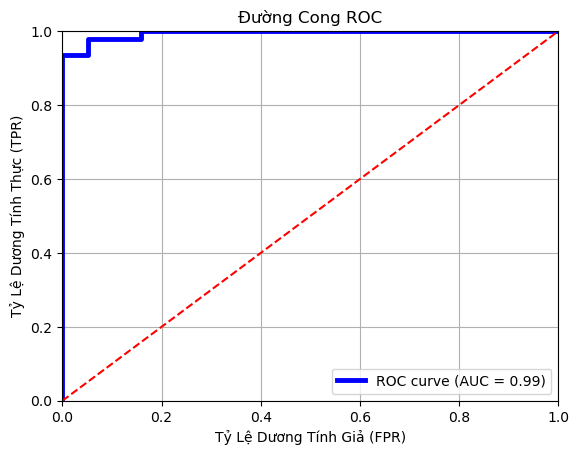

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=3.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Đường chéo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tỷ Lệ Dương Tính Giả (FPR)')
plt.ylabel('Tỷ Lệ Dương Tính Thực (TPR)')
plt.title('Đường Cong ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [30]:
# Hàm tính Cronbach's Alpha
def cronbach_alpha(data):
    items = data.shape[1]
    variance_total = data.var(ddof=1).sum()
    variance_items = data.var(ddof=1)
    return (items / (items - 1)) * (1 - (variance_items.sum() / variance_total))

alpha = cronbach_alpha(data)
print(f"Cronbach's Alpha: {alpha:.4f}")

Cronbach's Alpha: 0.0000


In [31]:
# Dự đoán xác suất trên tập kiểm tra
probabilities = model.predict(X_test)

# In hệ số tin cậy cho từng mẫu và lớp dự đoán
for i, prob in enumerate(probabilities):
    predicted_class = 1 if prob[0] >= 0.5 else 0  # Dự đoán lớp 1 nếu xác suất >= 0.5, ngược lại là lớp 0
    print(f'Mẫu {i + 1}: Hệ số tin cậy = {prob[0]:.4f}, Lớp dự đoán = {predicted_class}')

3/3 [==============================] - 0s 3ms/step
Mẫu 1: Hệ số tin cậy = 0.9958, Lớp dự đoán = 1
Mẫu 2: Hệ số tin cậy = 0.8922, Lớp dự đoán = 1
Mẫu 3: Hệ số tin cậy = 0.0469, Lớp dự đoán = 0
Mẫu 4: Hệ số tin cậy = 0.9899, Lớp dự đoán = 1
Mẫu 5: Hệ số tin cậy = 0.9568, Lớp dự đoán = 1
Mẫu 6: Hệ số tin cậy = 0.1996, Lớp dự đoán = 0
Mẫu 7: Hệ số tin cậy = 0.9362, Lớp dự đoán = 1
Mẫu 8: Hệ số tin cậy = 0.5620, Lớp dự đoán = 1
Mẫu 9: Hệ số tin cậy = 0.5408, Lớp dự đoán = 1
Mẫu 10: Hệ số tin cậy = 0.9884, Lớp dự đoán = 1
Mẫu 11: Hệ số tin cậy = 0.9949, Lớp dự đoán = 1
Mẫu 12: Hệ số tin cậy = 0.9140, Lớp dự đoán = 1
Mẫu 13: Hệ số tin cậy = 0.9995, Lớp dự đoán = 1
Mẫu 14: Hệ số tin cậy = 0.9831, Lớp dự đoán = 1
Mẫu 15: Hệ số tin cậy = 0.9714, Lớp dự đoán = 1
Mẫu 16: Hệ số tin cậy = 0.7091, Lớp dự đoán = 1
Mẫu 17: Hệ số tin cậy = 0.4893, Lớp dự đoán = 0
Mẫu 18: Hệ số tin cậy = 0.9951, Lớp dự đoán = 1
Mẫu 19: Hệ số tin cậy = 0.1718, Lớp dự đoán = 0
Mẫu 20: Hệ số tin cậy = 0.9934, Lớp dự đoán = 